# Introduction

The objective of this project is to apply machine learning on a Kaggle dataset called Titanic : https://www.kaggle.com/c/titanic

This dataset is split into 2 csv files: 
    1. train.csv
    2. test.csv

The idea is to predict who died on test.csv file based on train.csv file.

# Data Exploration

In [8]:
# Import libraries for data exploration
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Create datasets with our 2 csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dfs = [test,train]

In [10]:
# Preview Data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
# Check data quality
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We notice that there are missing 'Age' values (714/891)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
uniqueSex = train['Sex'].unique()
uniqueSex

array(['male', 'female'], dtype=object)

<AxesSubplot:>

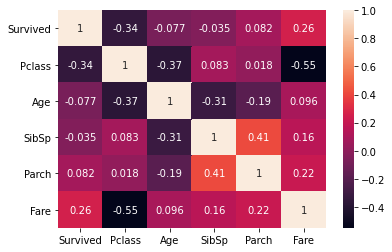

In [14]:
corr_df = train.drop(['PassengerId'], axis=1)
corr = corr_df.corr()
sns.heatmap(corr,annot=True)

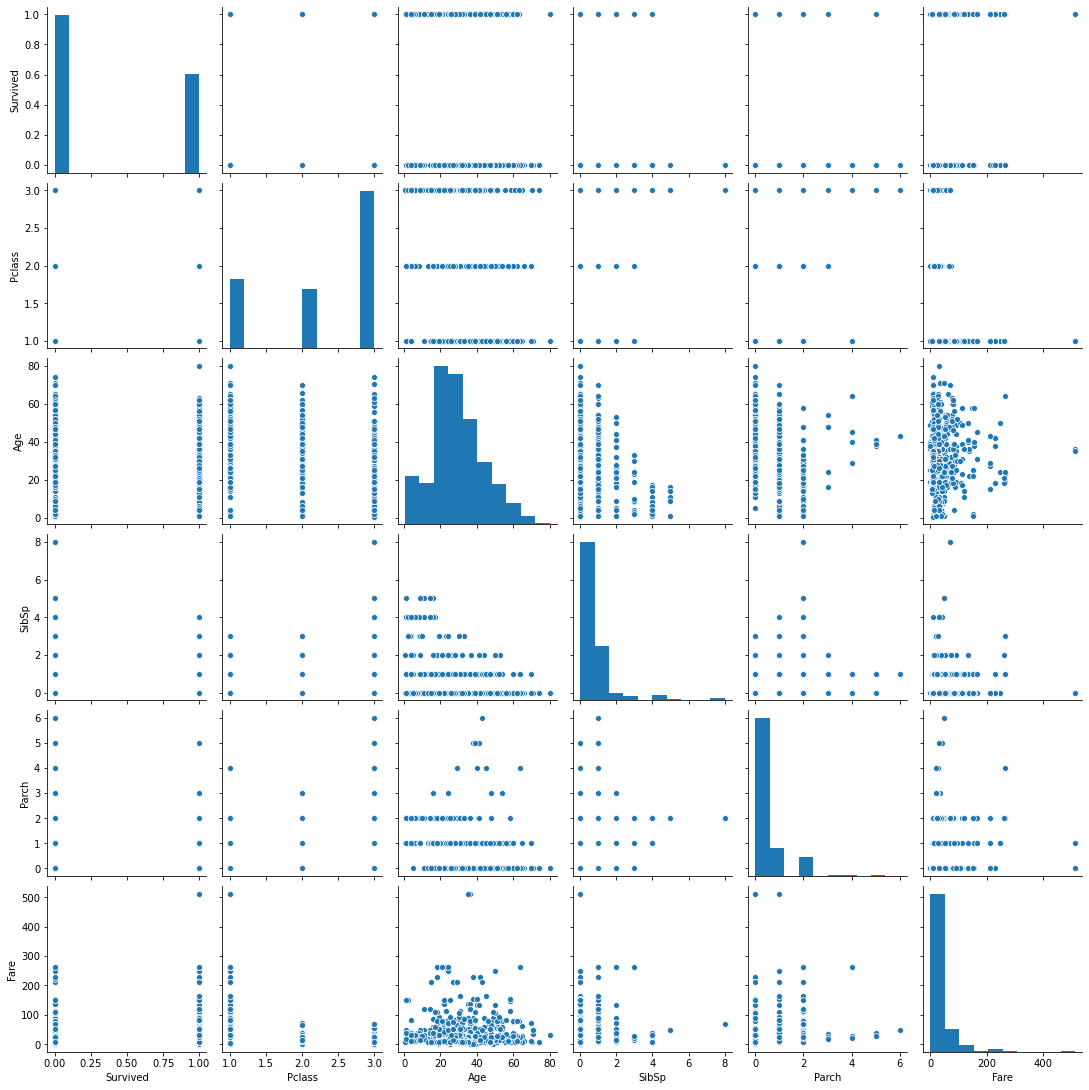

In [15]:
sns.pairplot(corr_df)

In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's take a look at remaining attributes:
    1. Name
    2. Age
    3. Ticket
    4. Fare
    5. Cabin

For 'Name', we notice that there are some text that could be useful to analyze. 
After the comma, we can see these values:
    1. Mr
    2. Miss
    3. Mrs
    
We'll try to retrieve all these values and check if it's correlated to survival rate

In [17]:
train['Title1'] = train['Name'].str.split(',').str[-1]
train['Title'] = train['Title1'].str.split('.').str[0]
del train['Title1']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [18]:
train.groupby('Title').count()['PassengerId']

Title
 Capt              1
 Col               2
 Don               1
 Dr                7
 Jonkheer          1
 Lady              1
 Major             2
 Master           40
 Miss            182
 Mlle              2
 Mme               1
 Mr              517
 Mrs             125
 Ms                1
 Rev               6
 Sir               1
 the Countess      1
Name: PassengerId, dtype: int64

I'd say that this feature is too related to Sex and Age to be a good feature.

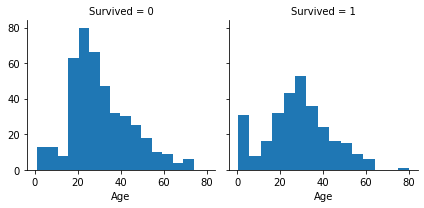

In [19]:
# Age
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=15)

Age is definitely a good feature.

# Data Preparation

In this step, we'll modify the data to be numerical.

In [20]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [21]:
# We have to modify the data for both train and test
train = train.drop(['Title'], axis=1)

In [22]:
train['Sex'] = train['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
test['Sex'] = test['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [23]:
train = train.drop(columns = ['PassengerId','Name','Ticket','Fare','Cabin'])
test = test.drop(columns = ['Name','Ticket','Fare','Cabin'])
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,0,22.0,1,0,S
1,1,1,1,38.0,1,0,C
2,1,3,1,26.0,0,0,S
3,1,1,1,35.0,1,0,S
4,0,3,0,35.0,0,0,S


## Age
We'll fill the missing Age values based on Sex and Pclass

In [24]:
train_age = train[train['Age'].notna()]
table = pd.pivot_table(train_age, values='Age', index=['Pclass', 'Sex'], aggfunc=np.average)
table

Age
Pclass Sex           
1      0    41.281386
       1    34.611765
2      0    30.740707
       1    28.722973
3      0    26.507589
       1    21.750000

In [25]:
train['Age'].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [26]:
train['Age'] = train['Age'].replace(np.nan, '0', regex=True)
train['Age'] = train['Age'].astype(int)
train.loc[(train['Pclass'] == 1) & (train['Sex'] == 0) & (train['Age'] == 0), 'Age'] = 41
train.loc[(train['Pclass'] == 1) & (train['Sex'] == 1) & (train['Age'] == 0), 'Age'] = 35
train.loc[(train['Pclass'] == 2) & (train['Sex'] == 0) & (train['Age'] == 0), 'Age'] = 31
train.loc[(train['Pclass'] == 2) & (train['Sex'] == 1) & (train['Age'] == 0), 'Age'] = 29
train.loc[(train['Pclass'] == 3) & (train['Sex'] == 0) & (train['Age'] == 0), 'Age'] = 27
train.loc[(train['Pclass'] == 3) & (train['Sex'] == 1) & (train['Age'] == 0), 'Age'] = 22
train.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.597082,0.523008,0.381594
std,0.486592,0.836071,0.477990,13.019620,1.102743,0.806057
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,27.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000


In [27]:
train.dtypes

Survived     int64
Pclass       int64
Sex          int32
Age          int32
SibSp        int64
Parch        int64
Embarked    object
dtype: object

In [28]:
test['Age'] = test['Age'].replace(np.nan, '0', regex=True)
test['Age'] = test['Age'].astype(int)
test.loc[(train['Pclass'] == 1) & (test['Sex'] == 0) & (test['Age'] == 0), 'Age'] = 41
test.loc[(train['Pclass'] == 1) & (test['Sex'] == 1) & (test['Age'] == 0), 'Age'] = 35
test.loc[(train['Pclass'] == 2) & (test['Sex'] == 0) & (test['Age'] == 0), 'Age'] = 31
test.loc[(train['Pclass'] == 2) & (test['Sex'] == 1) & (test['Age'] == 0), 'Age'] = 29
test.loc[(train['Pclass'] == 3) & (test['Sex'] == 0) & (test['Age'] == 0), 'Age'] = 27
test.loc[(train['Pclass'] == 3) & (test['Sex'] == 1) & (test['Age'] == 0), 'Age'] = 22
test.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,0.363636,30.399522,0.447368,0.392344
std,120.810458,0.841838,0.481622,12.542138,0.896760,0.981429
min,892.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,996.250000,1.000000,0.000000,22.000000,0.000000,0.000000
50%,1100.500000,3.000000,0.000000,27.000000,0.000000,0.000000
75%,1204.750000,3.000000,1.000000,38.000000,1.000000,0.000000
max,1309.000000,3.000000,1.000000,76.000000,8.000000,9.000000


In [29]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,0,22,1,0,S
1,1,1,1,38,1,0,C
2,1,3,1,26,0,0,S
3,1,1,1,35,1,0,S
4,0,3,0,35,0,0,S


In [30]:
train['AgeBand'] = pd.cut(train['Age'], 5)
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.921, 16.8]",0.516129
1,"(16.8, 32.6]",0.345309
2,"(32.6, 48.4]",0.414747
3,"(48.4, 64.2]",0.434783
4,"(64.2, 80.0]",0.090909


In [31]:
train.dtypes

Survived       int64
Pclass         int64
Sex            int32
Age            int32
SibSp          int64
Parch          int64
Embarked      object
AgeBand     category
dtype: object

In [32]:
train['Age'] = train['Age'].astype(int)
train.loc[ train['Age'] <= 16, 'Age'] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 32), 'Age'] = 1
train.loc[(train['Age'] > 32) & (train['Age'] <= 48), 'Age'] = 2
train.loc[(train['Age'] > 48) & (train['Age'] <= 64), 'Age'] = 3
train.loc[ train['Age'] > 64, 'Age'] = 4

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,AgeBand
0,0,3,0,1,1,0,S,"(16.8, 32.6]"
1,1,1,1,2,1,0,C,"(32.6, 48.4]"
2,1,3,1,1,0,0,S,"(16.8, 32.6]"
3,1,1,1,2,1,0,S,"(32.6, 48.4]"
4,0,3,0,2,0,0,S,"(32.6, 48.4]"


In [33]:
test.loc[ test['Age'] <= 16, 'Age'] = 0
test.loc[(test['Age'] > 16) & (test['Age'] <= 32), 'Age'] = 1
test.loc[(test['Age'] > 32) & (test['Age'] <= 48), 'Age'] = 2
test.loc[(test['Age'] > 48) & (test['Age'] <= 64), 'Age'] = 3
test.loc[ test['Age'] > 64, 'Age'] = 4
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,892,3,0,2,0,0,Q
1,893,3,1,2,1,0,S
2,894,2,0,3,0,0,Q
3,895,3,0,1,0,0,S
4,896,3,1,1,1,1,S


In [34]:
train.dtypes

Survived       int64
Pclass         int64
Sex            int32
Age            int32
SibSp          int64
Parch          int64
Embarked      object
AgeBand     category
dtype: object

In [35]:
train['Embarked'] = train['Embarked'].replace(np.nan, 'S', regex=True)
train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [36]:
test['Embarked'].unique()

array(['Q', 'S', 'C'], dtype=object)

In [37]:
train['Embarked'] = train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test['Embarked'] = test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,AgeBand
0,0,3,0,1,1,0,0,"(16.8, 32.6]"
1,1,1,1,2,1,0,1,"(32.6, 48.4]"
2,1,3,1,1,0,0,0,"(16.8, 32.6]"
3,1,1,1,2,1,0,0,"(32.6, 48.4]"
4,0,3,0,2,0,0,0,"(32.6, 48.4]"


In [38]:
train = train.drop(columns = ['AgeBand'])
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,0,1,1,0,0
1,1,1,1,2,1,0,1
2,1,3,1,1,0,0,0
3,1,1,1,2,1,0,0
4,0,3,0,2,0,0,0


<AxesSubplot:>

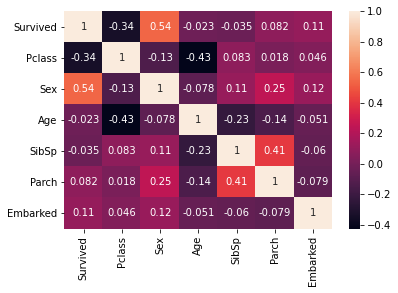

In [39]:
corr = train.corr()
sns.heatmap(corr,annot=True)

In [40]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,892,3,0,2,0,0,2
1,893,3,1,2,1,0,0
2,894,2,0,3,0,0,2
3,895,3,0,1,0,0,0
4,896,3,1,1,1,1,0


# Machine Learning Models

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [42]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 6), (891,), (418, 6))

In [43]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.58

In [44]:
coeff_df = pd.DataFrame(train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.587972
5,Embarked,0.235676
4,Parch,-0.021066
3,SibSp,-0.292896
2,Age,-0.588688
0,Pclass,-1.200252


In [45]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.08

In [46]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.08

In [47]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)

In [48]:
submission = pd.read_csv('submission.csv')
submission.Survived.mean()

0.2942583732057416

In [2]:
from checkAccuracy import accuracy
print(accuracy)

0.7642857142857142
